#Import Libary & Menginstall Libary yang di butuh kan

In [ ]:
#Library yaitu Speech Recognition dan Google Text To Speech
!pip -q install speechrecognition
!pip -q install gtts

     |████████████████████████████████| 32.8 MB 138 kB/s 
     |████████████████████████████████| 62 kB 428 kB/s 
     |████████████████████████████████| 96 kB 2.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.1.3 which is incompatible.


In [ ]:
import json
import nltk
import time
import random
import string
import pickle
import numpy as np
import pandas as pd
from gtts import gTTS
from io import BytesIO
import tensorflow as tf
import IPython.display as ipd
import speech_recognition as sr
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Model
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten, Dense, GlobalMaxPool1D

In [ ]:
# Package sentence tokenizer
nltk.download('punkt')
# Package lemmatization
nltk.download('wordnet')
# Package multilingual wordnet data
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

#Load Google Drive & memanggil dataset dari Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing the dataset
with open('/content/drive/MyDrive/MidTest Tawang sahro winanto/Final test/Final_test.json') as content:
  data1 = json.load(content)

# Mendapatkan semua data ke dalam list
tags = [] # data tag
inputs = [] # data input atau pattern
responses = {} # data respon
words = [] # Data kata
classes = [] # Data Kelas atau Tag
documents = [] # Data Kalimat Dokumen
ignore_words = ['?', '!'] # Mengabaikan tanda spesial karakter

for intent in data1['intents']:
  responses[intent['tag']]=intent['respons']
  for lines in intent['input']:
    inputs.append(lines)
    tags.append(intent['tag'])
    for pattern in intent['input']:
      w = nltk.word_tokenize(pattern)
      words.extend(w)
      documents.append((w, intent['tag']))
      # add to our classes list
      if intent['tag'] not in classes:
        classes.append(intent['tag'])

# Konversi data json ke dalam dataframe
data = pd.DataFrame({"patterns":inputs, "tags":tags})

In [ ]:
data

,patterns,tags
0,Hallo,salam
1,Hai,salam
2,Hei,salam
3,Halo,salam
4,Bro,salam
...,...,...
170,Berapa minimal free course yang di mabil?,Minimal_free_course
171,Berapa free course yang harus di ambil,Minimal_free_course
172,Minimal berapa free course yang di ambil ?,Minimal_free_course
173,Apa sih softskill?,Softskill


# Preprocesing data
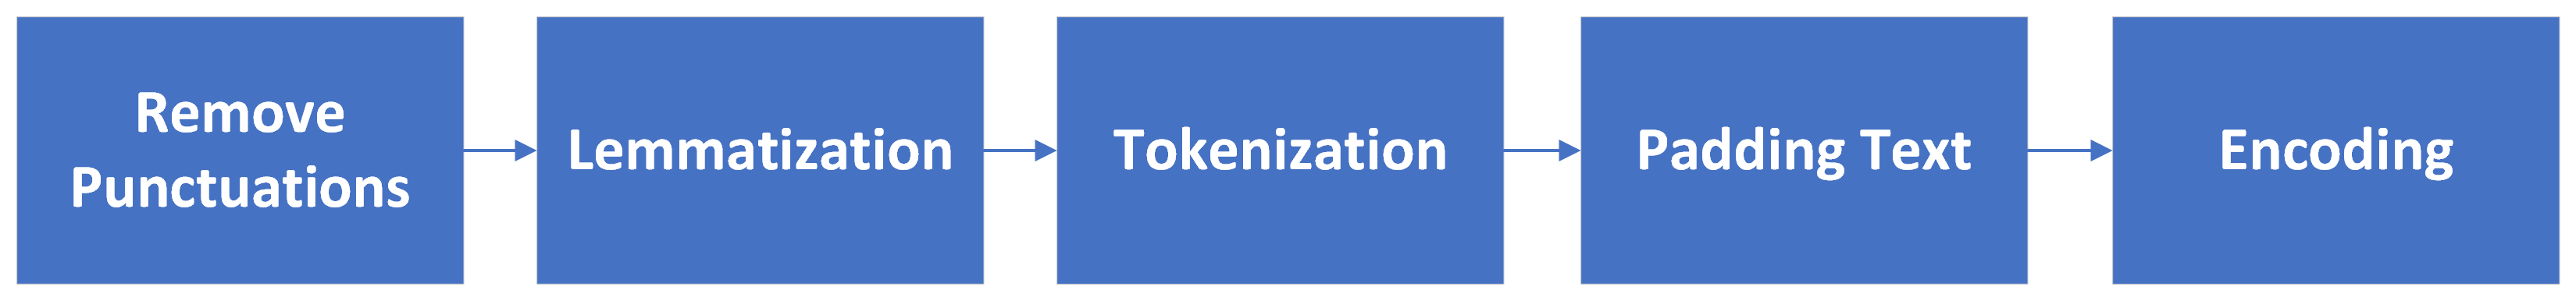

Remove Punctuations

In [ ]:
# Removing Punctuations (Menghilangkan Punktuasi)
data['patterns'] = data['patterns'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data['patterns'] = data['patterns'].apply(lambda wrd: ''.join(wrd))

Lemmatization (Lematisasi)

In [ ]:
lemmatizer = WordNetLemmatizer()
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))

print (len(words), "unique lemmatized words", words)

146 unique lemmatized words ['ada', 'ai', 'ai-blockchain', 'ai-game', 'ai-hipster', 'ai-hustler', 'ai-infra', 'ai-manufacture', 'ai-research', 'aia', 'aja', 'akan', 'ambil', 'animator', 'apa', 'apakah', 'backend', 'bakal', 'belajar', 'berapa', 'berikan', 'bibot', 'bisa', 'bro', 'buat', 'buka', 'business', 'bye', 'cara', 'ciptakan', 'community', 'content', 'course', 'coworking', 'creator', 'cx', 'dah-dah', 'dan', 'dari', 'data', 'design', 'developer', 'development', 'di', 'digital', 'dong', 'editor', 'engineering', 'free', 'full', 'game', 'gimana', 'graphic', 'hai', 'hallo', 'halo', 'harus', 'hei', 'helamat', 'id', 'ikut', 'ikutin', 'influencer', 'infonya', 'informasinya', 'instruktur', 'itu', 'jelaskan', 'jumpa', 'kampus', 'kasih', 'kelas', 'kenapa', 'kerjakan', 'kita', 'lagi', 'mabil', 'magang', 'maksud', 'malam', 'mana', 'manager', 'mandiri', 'mau', 'mechanical', 'melalui', 'membuka', 'memperlajarin', 'mempunyai', 'mengikutin', 'merdeka', 'minimal', 'mobile', 'msib', 'nanti', 'ngambi

Menyortir Data Kelas Tags

In [ ]:
# sort classes
classes = sorted(list(set(classes)))
print (len(classes), "classes", classes)

50 classes ['Apa_itu_pembelajaran_mandiri', 'Apa_itu_pembelajaran_terjadwal', 'Bibot', 'Di_mana_pembelajaran_tamu', 'Minimal_free_course', 'Minimal_kelas_yang_di ambil', 'Pembelajaran_tamu', 'Pencipta_bibot', 'Program_magang_bisaAi', 'Program_prakerja_bisaAI', 'Siapa_tawang', 'Softskill', 'bisaAi', 'kampus_merdeka', 'magang_Backend_Programmer', 'magang_Business_Development', 'magang_Community_Manager', 'magang_Content_Creator_dan_Technical_Writer', 'magang_Coworking_Space_Manager', 'magang_Design_Engineering_dan_Mechanical_Engineering', 'magang_Game_Developer_dan_Animator', 'magang_Influencer', 'magang_Instruktur_DatavScience', 'magang_Instruktur_Full_Stack_Programming', 'magang_Mobile_Programmer', 'magang_Pemasaran_Digital', 'magang_Penjualan', 'magang_Program_Manager', 'magang_UI/UX_dan_CX', 'magang_Video_dan_Graphic_Design_Editor', 'magang_Web_Programmer', 'msib_bisaAI', 'penjelasan_msib', 'penjelasan_program_prakerja', 'program_bisaAi_kampus_merdeka', 'program_bisa_ai', 'program_si

Tokenization (Tokenisasi)

In [ ]:
# Tokenize the data (Tokenisasi Data)
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['patterns'])
train = tokenizer.texts_to_sequences(data['patterns'])
train

[[109],
 [110],
 [111],
 [112],
 [113],
 [114, 115],
 [39, 116],
 [39, 117],
 [39, 118],
 [44, 45],
 [119],
 [39, 120],
 [44, 45, 121],
 [122, 123, 124],
 [44, 45, 125],
 [126],
 [1, 10, 18],
 [21, 18],
 [18, 10, 1],
 [21, 4, 93, 18],
 [94, 18, 21],
 [21, 94, 18],
 [18, 2, 46, 95, 21],
 [2, 93, 95, 21, 18],
 [21, 47],
 [47, 10, 21],
 [21, 47, 127, 128],
 [1, 48, 2, 46, 18],
 [1, 12, 18],
 [129, 18, 2, 46],
 [48, 18, 1],
 [1, 12, 96, 18],
 [1, 48, 18],
 [1, 10, 6, 9],
 [97, 98, 49, 99, 6, 9],
 [1, 50, 6, 9, 10],
 [29, 1, 10, 6, 9],
 [6, 9, 10, 1],
 [1, 10, 22, 23],
 [29, 49, 1, 10, 22, 23],
 [97, 98, 49, 99, 22, 23],
 [22, 23],
 [29, 1, 10, 22, 23],
 [20, 1, 5, 11, 96, 6, 9],
 [20, 1, 5, 2, 6, 9],
 [6, 9, 130, 11, 1, 5],
 [1, 10, 24],
 [1, 4, 2, 100, 11, 24],
 [24],
 [11, 24, 10, 1],
 [20, 11, 24, 1, 5],
 [1, 5, 11, 24, 2, 6, 9],
 [24, 10, 1],
 [20, 11, 24, 1, 5, 2, 6, 9],
 [24, 6, 9, 20, 11, 1, 5],
 [11, 1, 4, 2, 101, 22, 23, 1, 4, 2, 101, 6, 9],
 [2, 22, 23, 6, 9, 102, 11, 1],
 [1, 5,

Padding

In [ ]:
# Apply padding
x_train = pad_sequences(train)
print(x_train) # Padding Sequences

[[  0   0   0 ...   0   0 109]
 [  0   0   0 ...   0   0 110]
 [  0   0   0 ...   0   0 111]
 ...
 [  0   0   0 ...   4   2  90]
 [  0   0   0 ...   1  50 108]
 [  0   0   0 ... 108  10   1]]


Encoding Text

In [ ]:
# Encoding the outputs
le = LabelEncoder()
y_train = le.fit_transform(data['tags'])
print(y_train) #Label Encodings

[37 37 37 37 37 37 37 37 37 38 38 38 38 38 38 38  2  2  2  7  7  7  7  7
 10 10 10 49 49 49 49 49 49 12 12 12 12 12 13 13 13 13 13 35 35 35 33 33
 33 33  9  9  9  9  9 34 34 34 34 32 32 32 31 31 31  8  8  8  8 14 14 14
 15 15 15 16 16 16 17 17 17 18 18 18 19 19 19 20 20 20 21 21 21 22 22 22
 23 23 23 24 24 24 25 25 25 26 26 26 27 27 27 28 28 28 29 29 29 30 30 30
 47 47 47 47 48 48 48 36 36 36 36 43 43 43 40 40 40 44 44 44 42 42 42 45
 45 45 46 46 46 41 41 41  6  6  6  3  3  3  3 39  1  1  1  5  5  5  0  0
  0  0  4  4  4 11 11]


#pembuatan model

Input Length, Output Length and Vocabulary

In [ ]:
# input length
input_shape = x_train.shape[1]
print(input_shape)

13


In [ ]:
# define vocabulary
vocabulary = len(tokenizer.word_index)
print("number of unique words : ", vocabulary)

# output length
output_length = le.classes_.shape[0]
print("output length: ", output_length)

number of unique words :  147
output length:  50


In [ ]:
from keras.layers import Embedding, SpatialDropout1D, LSTM, Dense
# Creating the model (Membuat Modeling)
i = Input(shape=(input_shape,))
x = Embedding(vocabulary+1,10)(i) # Layer Embedding
x = SpatialDropout1D(0.2)(x)
x = LSTM(800, return_sequences=True)(x) # Layer Long Short Term Memory
x = Flatten()(x) # Layer Flatten
x = Dense(output_length, activation="softmax")(x) # Layer Dense
model  = Model(i,x)

# Compiling the model (Kompilasi Model)
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13)]              0         
                                                                 
 embedding (Embedding)       (None, 13, 10)            1480      
                                                                 
 spatial_dropout1d (SpatialD  (None, 13, 10)           0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 13, 800)           2595200   
                                                                 
 flatten (Flatten)           (None, 10400)             0         
                                                                 
 dense (Dense)               (None, 50)                520050    
                                                             

In [ ]:
History = model.fit(x_train, y_train, epochs=150)

Epoch 1/150
6/6 [==============================] - 5s 292ms/step - loss: 3.9141 - accuracy: 0.0400
Epoch 2/150
6/6 [==============================] - 2s 297ms/step - loss: 3.8871 - accuracy: 0.0629
Epoch 3/150
6/6 [==============================] - 2s 290ms/step - loss: 3.8101 - accuracy: 0.0743
Epoch 4/150
6/6 [==============================] - 2s 294ms/step - loss: 3.7060 - accuracy: 0.0457
Epoch 5/150
6/6 [==============================] - 2s 298ms/step - loss: 3.6079 - accuracy: 0.0571
Epoch 6/150
6/6 [==============================] - 2s 303ms/step - loss: 3.5417 - accuracy: 0.0857
Epoch 7/150
6/6 [==============================] - 2s 305ms/step - loss: 3.4913 - accuracy: 0.0914
Epoch 8/150
6/6 [==============================] - 2s 306ms/step - loss: 3.4538 - accuracy: 0.0857
Epoch 9/150
6/6 [==============================] - 2s 292ms/step - loss: 3.4374 - accuracy: 0.0743
Epoch 10/150
6/6 [==============================] - 2s 307ms/step - loss: 3.3680 - accuracy: 0.0914
Epoch 11/

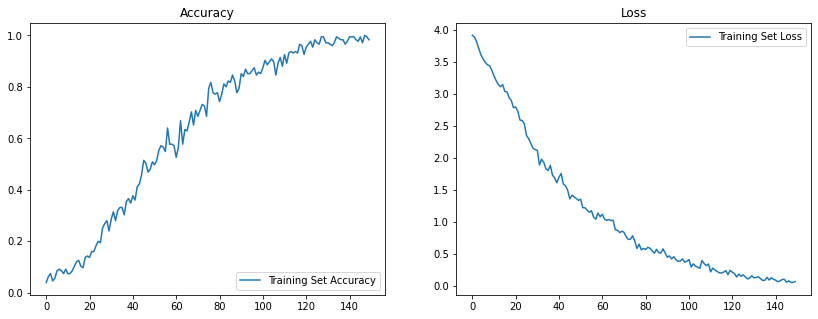

In [ ]:
# Plotting model Accuracy and Loss (Visualisasi Plot Hasil Akurasi dan Loss)
# Plot Akurasi
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(History.history['accuracy'],label='Training Set Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(History.history['loss'],label='Training Set Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

#test Chatbot

In [ ]:
# Membuat Input Chat
while True:
  texts_p = []
  prediction_input = input('👨‍🦰 Kamu : ')

  # Menghapus punktuasi dan konversi ke huruf kecil
  prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  texts_p.append(prediction_input)

  # Tokenisasi dan Padding
  prediction_input = tokenizer.texts_to_sequences(texts_p)
  prediction_input = np.array(prediction_input).reshape(-1)
  prediction_input = pad_sequences([prediction_input],input_shape)

  # Mendapatkan hasil keluaran pada model
  output = model.predict(prediction_input)
  output = output.argmax()

  # Menemukan respon sesuai data tag dan memainkan voice bot
  response_tag = le.inverse_transform([output])[0]
  print("🤖 Bibot : ", random.choice(responses[response_tag]))
  tts = gTTS(random.choice(responses[response_tag]), lang='id')
  # Simpan model voice bot ke dalam Google Drive
  tts.save('/content/drive/MyDrive/MidTest Tawang sahro winanto/Final test/suarabibot.wav')
  time.sleep(0.08)
  # Load model voice bot from Google Drive
  ipd.display(ipd.Audio('/content/drive/MyDrive/MidTest Tawang sahro winanto/Final test/suarabibot.wav', autoplay=False))
  print("="*60 + "\n")
  # Tambahkan respon 'goodbye' agar bot bisa berhenti
  if response_tag == "selesai":
    break

👨‍🦰 Kamu : halo
1/1 [==============================] - 1s 572ms/step
🤖 Bibot :  Hallo Bibot di sini ada yang bisa saya bantu ?



👨‍🦰 Kamu : apa itu bibot
1/1 [==============================] - 0s 32ms/step
🤖 Bibot :  Bibot merupakan sebuah chatbot dari Bisa Ai



👨‍🦰 Kamu : siapa yang buat ?
1/1 [==============================] - 0s 42ms/step
🤖 Bibot :  Bibot di ciptakan dari salah satu perseta sib bisa ai batch 3 yaitu Tawang sahro winanto



👨‍🦰 Kamu : tujuan di buat bibot?
1/1 [==============================] - 0s 31ms/step
🤖 Bibot :  Tujuan dari di ciptakan nya bibot adalah untuk membantu teman teman mencari tau seputar bisa ai



👨‍🦰 Kamu : bisa ai itu apa ?
1/1 [==============================] - 0s 36ms/step
🤖 Bibot :  BISA AI merupakan start up yang mengembangkan layanan dan produk seputar Artificial Intelligence yang didirikan pada tahun 2019.



👨‍🦰 Kamu : ada apa aja di bisa ai
1/1 [==============================] - 0s 35ms/step
🤖 Bibot :   di bisa ai ada program prakerja dan kampus merdeka



👨‍🦰 Kamu : apa itu ai research
1/1 [==============================] - 0s 33ms/step
🤖 Bibot :  MSIB atau Magang dan Studi Independen Bersertifikat adalah salah satu program Kampus Merdeka yang dirancang untuk memastikan mahasiswa mendapatkan keterampilan dan kompetensi utama, terbaik, dan terkini untuk menghadapi dunia masa depan.



👨‍🦰 Kamu : apa itu pembelajaran terjadwal
1/1 [==============================] - 0s 32ms/step
🤖 Bibot :  Pembelajaran tamu merupakan pembelajaran dengan mengikutin webinar dari mentor mentor Bisa Ai dan selama program kampus merdeka peserta minimal mengikutin 10X pembelajaran tamu



👨‍🦰 Kamu : pembelajaran terjadwal itu apa ?
1/1 [==============================] - 0s 32ms/step
🤖 Bibot :  Pembelajran terjadwal merupakan perserta mengikutin kelas yang sudah perserta pilih



👨‍🦰 Kamu : minimal ngambil berapa kelas?
1/1 [==============================] - 0s 42ms/step
🤖 Bibot :  Minimal kelas yang di ambil di pembelajaran terjadwal yaitu sebanyak 5 kelas yaitu kelas wajib 3 dan kelas pilihan 2



👨‍🦰 Kamu : bye
1/1 [==============================] - 0s 31ms/step
🤖 Bibot :  dadah Semoga harimu menyenangkan sampai jumpa lagi


In [ ]:
model.save('/content/drive/MyDrive/MidTest Tawang sahro winanto/Final test/chat_model.h5')

print('Model Created Successfully!')

Model Created Successfully!
